# Blob Detection Workflow

This example shows a compact image-analysis pipeline that detects bright blobs in two sample images using DataJoint. It demonstrates:

- Seeding a small `Image` manual table with two entries of standard images from `skimage.data`.
- Defining multiple parameter sets for blob detection in a lookup table `BlobParamSet`
- Defining a computed master table `Detection` together with its nested part table `Detection.Blob`.
- Populating the master, which automatically inserts all part rows inside the same transaction.
- Visualizing the results by drawing detection circles on the images.
- Visually selecting the optimal parameter set for each image and saving the selection in a manual table `SelectDetection`.

Along the way we illustrate why master-part relationships are ideal for computational workflows: the master stores aggregate results and the parts hold per-feature detail, all created atomically.


## Setup

Load the required images and display them for reference.


In [25]:
%xmode minimal

Exception reporting mode: Minimal


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import data
from skimage.feature import blob_doh
from skimage.color import rgb2gray

import datajoint as dj
schema = dj.Schema('image_analysis')

In [27]:
@schema
class Image(dj.Manual):
    definition = """
    image_id : int
    ---
    image_name : varchar(30)
    image : longblob
    """

Image.insert(
    (
        (1, "hubble deep field", rgb2gray(data.hubble_deep_field())),
        (2, "human mitosis", data.human_mitosis()/255.0)
    ), skip_duplicates=True
);

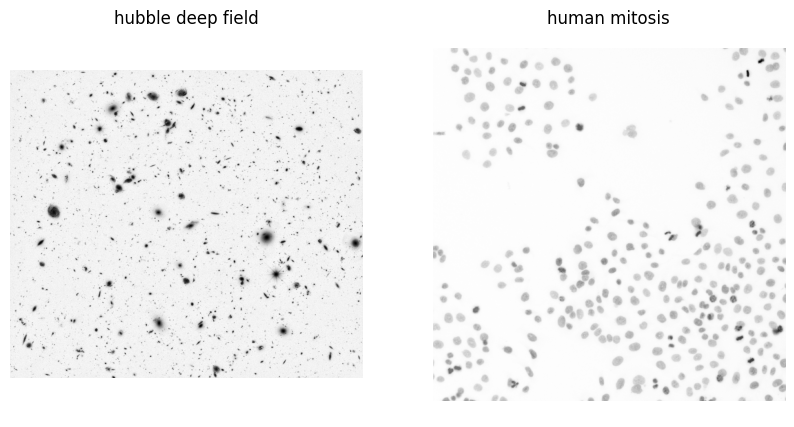

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, image, title in zip(axs, *Image.fetch("image", "image_name")):
    ax.imshow(image, cmap="gray_r")
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(title)


In [29]:
@schema
class BlobParamSet(dj.Lookup):
    definition = """
    blob_paramset : int
    ---
    min_sigma : float
    max_sigma : float
    threshold : float
    """
    contents = [
        (1, 2.0, 6.0, 0.001),
        (2, 3.0, 8.0, 0.002),
        (3, 4.0, 20.0, 0.01),
    ]


@schema
class Detection(dj.Computed):
    definition = """
    -> Image
    -> BlobParamSet
    ---
    nblobs : int
    """

    class Blob(dj.Part):
        definition = """
        -> master
        blob_id : int
        ---
        x : float
        y : float
        r : float
        """

    def make(self, key):
        # fetch inputs
        img = (Image & key).fetch1("image")
        params = (BlobParamSet & key).fetch1()

        # compute results
        blobs = blob_doh(
            img, 
            min_sigma=params['min_sigma'], 
            max_sigma=params['max_sigma'], 
            threshold=params['threshold'])

        # insert master and parts
        self.insert1(dict(key, nblobs=len(blobs)))
        self.Blob.insert(
            (dict(key, blob_id=i, x=x, y=y, r=r)
             for i, (x, y, r) in enumerate(blobs)))

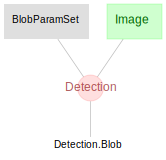

In [30]:
dj.Diagram(schema)

In [31]:
Detection.populate(display_progress=True)

Detection: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


{'success_count': 6, 'error_list': []}

In [32]:
Detection()

image_id,blob_paramset,nblobs
1,1,1921
1,2,971
1,3,229
2,1,364
2,2,232
2,3,11


## Parameter sets

Define a small lookup table of blob-detection parameters.


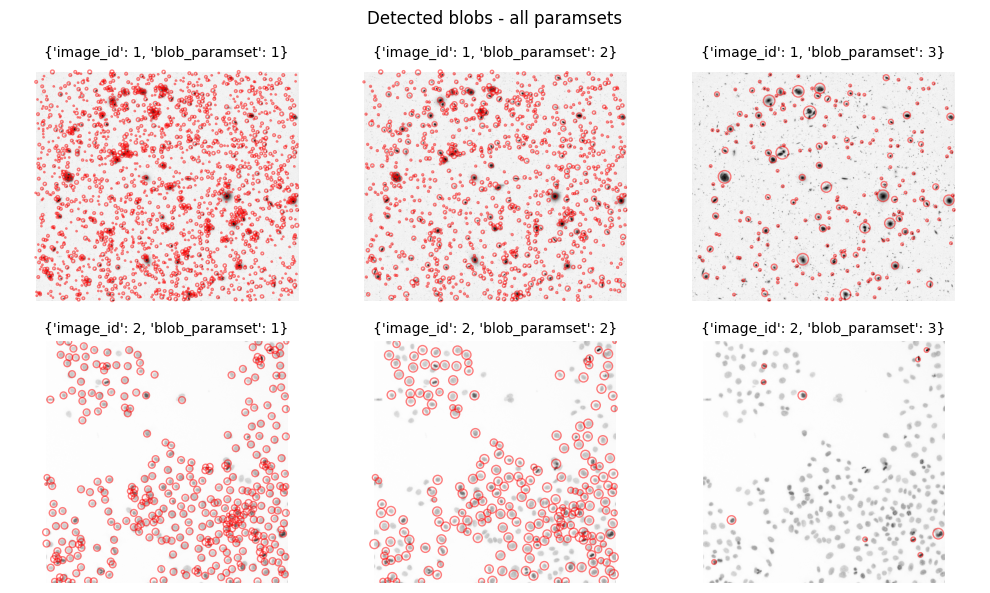

In [40]:
fix, axes = plt.subplots(2, 3, figsize=(10, 6))
for ax, key in zip(axes.ravel(), Detection.fetch("KEY", order_by="image_id, blob_paramset")):
    img = (Image & key).fetch1("image")
    ax.imshow(img, cmap="gray_r")
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(str(key), fontsize=10)
    for  x, y, r in zip(*(Detection.Blob & key).fetch("y", "x", "r")):
        c = plt.Circle((x, y), r*1.2, color='r', alpha=0.5, fill=False)
        ax.add_patch(c)
plt.suptitle("Detected blobs - all paramsets")
plt.tight_layout()

In [34]:
@schema
class SelectDetection(dj.Manual):
    definition = """
    -> Image
    ---
    -> Detection
    """
    

In [35]:
SelectDetection.insert1(dict(image_id=1, blob_paramset=3))
SelectDetection.insert1(dict(image_id=2, blob_paramset=1))

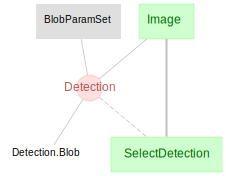

In [36]:
dj.Diagram(schema)

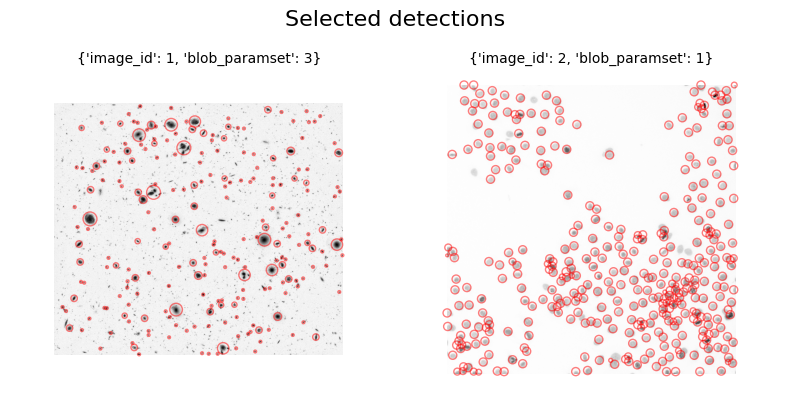

In [37]:
fix, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, key in zip(axes.ravel(), SelectDetection.fetch(as_dict=True, order_by="image_id")):
    img = (Image & key).fetch1("image")
    ax.imshow(img, cmap="gray_r")
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(str(key), fontsize=10)
    for  x, y, r in zip(*(Detection.Blob & key).fetch("y", "x", "r")):
        c = plt.Circle((x, y), r*1.2, color='r', alpha=0.5, fill=False)
        ax.add_patch(c)
plt.suptitle("Selected detections", fontsize=16)
plt.tight_layout()


## Detection master and part tables

`Detection` is a computed table. When `populate()` runs, its `make()` method:

1. Fetches the image and parameter set.
2. Runs `skimage.feature.blob_doh` to compute blobs.
3. Inserts one master row with the blob count.
4. Inserts one `Detection.Blob` part row per blob (containing coordinates and radius).

If any insert fails, the transaction is rolled back so master and parts stay synchronized.


## Results

Populate the detection table and display both the master summary and the per-blob annotations.


## Takeaways

- Master-part tables capture the structure “one job → many detailed results”.
- Downstream analyses depend only on the master (`-> Detection`) yet can access part details when needed.
- Populating the master guarantees atomic creation of all associated parts, preserving workflow integrity.


In [38]:
schema.drop() # drop the schema for re-generating the tutorial from scratch.